# Degree Correlation

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as st
import numpy as np
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression

# Functions

In [2]:
def createTableFromListOfString(lista,numCol):
    numCol=3
    col=0
    htmlTable="<table class='table table-striped'>"
    htmlTable+="<tr>"
    for item in lista:
        if(col==numCol):
            col=0
            htmlTable+="</tr>"

        htmlTable+="<td style='text-align: left; padding:10px; border:1px solid black'>"+item+"</td>"

        if(col==numCol):        
            htmlTable+="<tr>"
        else:
            col+=1        

    htmlTable+="</table>"
    htmlTable=htmlTable.replace("\n","<br>")
    display(HTML(htmlTable))
    
def hubsConnections(G,topHubs=10):
    degree =  dict(G.degree())
    top10Hubs = list(dict(sorted(degree.items(), key=lambda item: item[1],reverse=True)).items())[:topHubs]
    hubNeighbors={}
    for h1 in top10Hubs:
        n1=h1[0]
        hubNeighbors[n1]={}
        for h2 in top10Hubs:
            n2=h2[0]        
            neighbor = G.has_edge(n1,n2)
            hubNeighbors[n1][n2]=int(neighbor)

    df = pd.DataFrame(hubNeighbors)
    print(G.name,'Total:',df.to_numpy().sum())
    df['Total']=df.sum()
    return df.sort_values(by='Total',ascending=False)

#Let us assume that each node chooses randomly the nodes it connects to. Therefore the probability that nodes with degrees k and k′ link to each other is
# p(k1,k2)=k1k2/2L
def likehoodOfConnection(n1,n2,G):
    hub1=G.degree(n1)
    hub2=G.degree(n2)
    L=G.number_of_edges()
    return (hub1*hub2)/(2*L)

#Avarage Neighbors Degree
def averageNeighborsDegree(G,node):
    neighbors=list(nx.neighbors(G,node))
    if(len(neighbors)==0):
        return 0 
    else:
        return sum([nx.degree(G,n) for n in neighbors])/len(neighbors)

def averageNeighborsDegreeByDegree(G,ylim=(0,0),xlim=(0,0)):
    #Get only the Largest Connect Component
    G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    nodeWithDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in nodeWithDegreeK:
            nodeWithDegreeK[k]=[node]
        else:
            nodeWithDegreeK[k].append(node)
    #Get the average neighbors degree for every node with degree'k'
    for k in nodeWithDegreeK:
        means=0
        for node in nodeWithDegreeK[k]:
            means+=averageNeighborsDegree(G,node)
        nodeWithDegreeK[k]=round(means/len(nodeWithDegreeK[k]),2)

    #Plot the distribution
    plt.figure(figsize=(8,8))
    plt.loglog(list(nodeWithDegreeK.keys()),list(nodeWithDegreeK.values()),'o',color='rebeccapurple')
    #check the scale (custom ou default)
    if ylim==(0,0) or xlim==(0,0):
        ylim=plt.gca().get_ylim()
        xlim=plt.gca().get_xlim()

    #Plot the line for a random prediction
    degree = list(dict(G.degree).values())
    neutralNetwork=round((st.variance(degree) + st.mean(degree)**2)/st.mean(degree),2)
    randomPrediction=[neutralNetwork for x in range(int(xlim[1]*1.1))]    
    
    plt.loglog(range(int(xlim[1]*1.1)),randomPrediction,'-',color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('K',fontsize=16)
    plt.ylabel(r'$K_n$'r'$_n$(K)',rotation = 0,fontsize=16)
    #Hardcoded Solution because Actor Network is to big and take many hours to calculate de 'degree_assortativity_coefficient'
    if(G.name=='Actors'):
        print('Actors')
        plt.title(G.name)
    else:
        plt.title(G.name+'\n'+'Assortativity Coefficient: '+str(round(nx.assortativity.degree_assortativity_coefficient(G),2)))
    plt.show()

# Networks

In [3]:
networks={}
#Networks from the book Network Science
networks['Collaboration']=nx.read_edgelist('datasets/NetworkScienceBook_collaboration.edgelist.txt')
networks['Metabolic']=nx.read_edgelist('datasets/NetworkScienceBook_metabolic.edgelist.txt')
networks['Powergrid']=nx.read_edgelist('datasets/NetworkScienceBook_powergrid.edgelist.txt')
networks['Protein']=nx.read_edgelist('datasets/NetworkScienceBook_protein.edgelist.txt')
networks['Internet']=nx.read_edgelist('datasets/NetworkScienceBook_internet.edgelist.txt')
networks['Actors']=nx.read_edgelist('/DOUTORADO/Datasets/networks/RedeLivroNetworkScience/actor.edgelist.txt')
#Other Real Networks
#Reactome FI: https://reactome.org/download-data
networks['Reactome']=nx.from_pandas_edgelist(pd.read_csv('datasets/ProteinProteinInteractionNetwork_reactomeFI2019.tsv',sep='\t'),source='Gene1',target='Gene2')
#This Bacteria is a "KlebsiellaPneumoniae" downloaded from STRING: https://string-db.org/ 
networks['Bacteria']=nx.read_gml('datasets/ProteinProteinInteractionNetwork_KlebsiellaPneumoniae.gml')

#Synthetic Models
networks['ScaleFree1']=nx.barabasi_albert_graph(10000,3)
networks['ScaleFree2']=nx.dorogovtsev_goltsev_mendes_graph(9)
networks['Random']=nx.erdos_renyi_graph(10000,0.0006)

#Set the NX name
for net in networks:
    networks[net].name=net

#Show as a HTML Table
listOfInfo=[nx.info(networks[k]) for k in networks]
createTableFromListOfString(listOfInfo,3)

Name: CollaborationType: GraphNumber of nodes: 23133Number of edges: 93439Average degree: 8.0784,Name: MetabolicType: GraphNumber of nodes: 1039Number of edges: 4741Average degree: 9.1261,Name: PowergridType: GraphNumber of nodes: 4941Number of edges: 6594Average degree: 2.6691,Name: ProteinType: GraphNumber of nodes: 2018Number of edges: 2930Average degree: 2.9039,Name: InternetType: GraphNumber of nodes: 192244Number of edges: 609066Average degree: 6.3364,Name: ActorsType: GraphNumber of nodes: 702388Number of edges: 29397908Average degree: 83.7085,Name: ReactomeType: GraphNumber of nodes: 14071Number of edges: 268857Average degree: 38.2143,Name: BacteriaType: GraphNumber of nodes: 3546Number of edges: 12529Average degree: 7.0666,Name: ScaleFree1Type: GraphNumber of nodes: 10000Number of edges: 29991Average degree: 5.9982,Name: ScaleFree2Type: GraphNumber of nodes: 9843Number of edges: 19683Average degree: 3.9994,Name: RandomType: GraphNumber of nodes: 10000Number of edges: 29935Average degree: 5.9870


# Hubs Connecting to Hubs

In [4]:
[display(hubsConnections(networks[k],15)) for k in networks]

Collaboration Total: 58


,15755,11301,16896,21051,5012,21832,21067,3351,9885,9875,9877,20535,17897,4970,19556,Total
11301,1,0,0,1,0,0,1,1,1,1,1,0,0,0,0,7
15755,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,6
3351,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,6
9885,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,6
9875,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,6
9877,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,5
21051,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,4
17897,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,4
16896,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,3
21832,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,3


Metabolic Total: 156


,589,592,316,819,249,830,733,734,278,364,735,736,861,738,562,Total
589,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14
819,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,14
592,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,13
316,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,12
733,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,12
738,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,12
249,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,11
562,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,11
278,1,1,1,1,1,0,1,0,0,0,0,0,1,1,1,9
364,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,9


Powergrid Total: 2


,2553,4458,831,3468,4345,2542,2382,2575,2585,3895,1224,2617,2434,2662,2439,Total
2434,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2662,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3468,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4345,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Protein Total: 33


,1356,1400,1637,1017,528,161,514,372,1888,267,1883,1892,1441,30,1125,Total
372,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,6
1883,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,5
1356,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,4
1637,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,3
1888,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,3
1400,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
528,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
161,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2
1892,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2
30,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2


Internet Total: 18


,1736,8441,1306,6,868,10801,11061,103,382,12809,10181,3027,10894,14667,4846,Total
1736,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,3
382,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3
10181,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3
4846,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,3
6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2
8441,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
11061,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
10894,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
14667,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Actors Total: 210


,518308,311522,177498,19433,128289,62448,204735,414833,384296,269159,165952,279344,106485,162756,292764,Total
518308,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,14
311522,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,14
177498,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,14
19433,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,14
128289,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,14
62448,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,14
204735,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,14
414833,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,14
384296,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,14
269159,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,14


Reactome Total: 100


,EP300,GNB1,RPS27A,UBA52,PRKACA,UBC,STAT1,TP53,UBB,PRKACB,PRKACG,JUN,ARRB1,ARRB2,EGFR,Total
EP300,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,10
UBC,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,9
TP53,1,0,1,1,0,1,1,0,1,0,0,1,1,0,1,9
RPS27A,1,0,0,1,0,1,0,1,1,0,0,0,1,1,1,8
UBA52,1,0,1,0,0,1,0,1,1,0,0,0,1,1,1,8
UBB,1,0,1,1,0,1,0,1,0,0,0,0,1,1,1,8
JUN,1,0,0,0,1,1,1,1,0,1,1,0,1,0,0,8
ARRB1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,1,8
EGFR,0,0,1,1,0,1,1,1,1,0,0,0,1,1,0,8
ARRB2,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,6


Bacteria Total: 182


,573.JG24_10255,573.JG24_23480,573.JG24_23500,573.JG24_23435,573.JG24_30375,573.JG24_23465,573.JG24_23390,573.JG24_23410,573.JG24_23490,573.JG24_23470,573.JG24_23460,573.JG24_23040,573.JG24_23425,573.JG24_23420,573.JG24_23385,Total
573.JG24_23480,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,13
573.JG24_23500,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,13
573.JG24_23435,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,13
573.JG24_30375,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,13
573.JG24_23465,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,13
573.JG24_23390,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,13
573.JG24_23410,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,13
573.JG24_23490,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,13
573.JG24_23470,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,13
573.JG24_23460,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,13


ScaleFree1 Total: 68


,1,5,4,7,10,6,13,11,3,27,9,16,30,20,28,Total
5,1,0,1,1,1,1,0,0,1,1,0,0,1,0,0,8
4,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0,8
1,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,7
3,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,7
7,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,6
6,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,5
10,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,4
13,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,4
11,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,4
9,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,4


ScaleFree2 Total: 54


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,8
1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,0,8
2,1,1,0,0,1,1,0,1,0,0,1,0,0,1,1,8
3,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,4
4,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,4
5,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,4
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
7,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
9,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2


Random Total: 0


,3670,5400,7973,383,4575,245,1452,1719,2608,2613,2859,3085,3930,6040,6129,Total
3670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2608,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[None, None, None, None, None, None, None, None, None, None, None]

# Assortativity

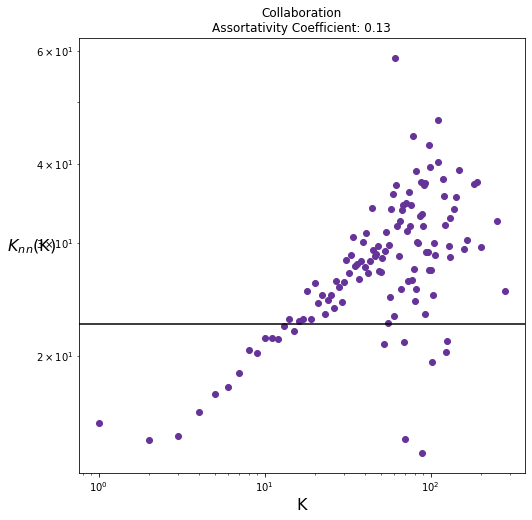

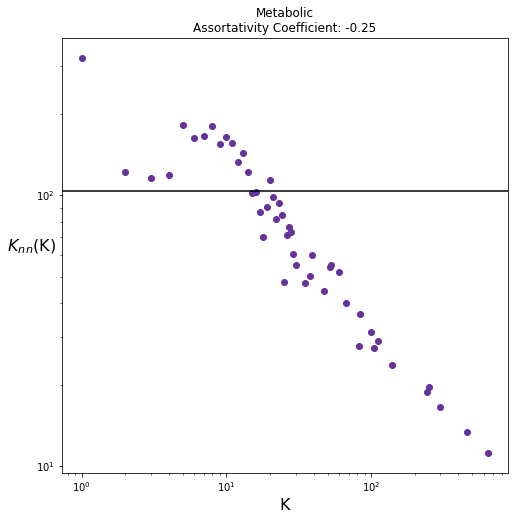

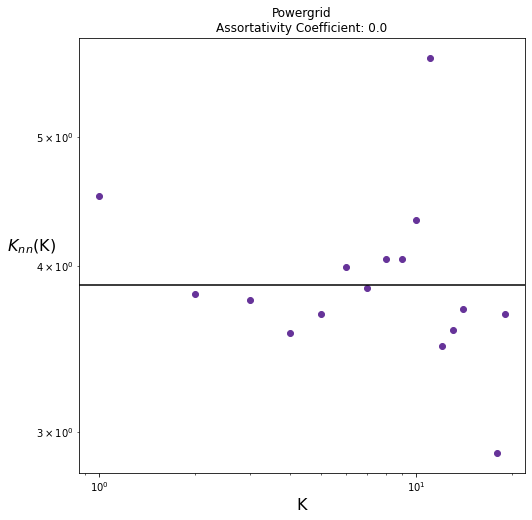

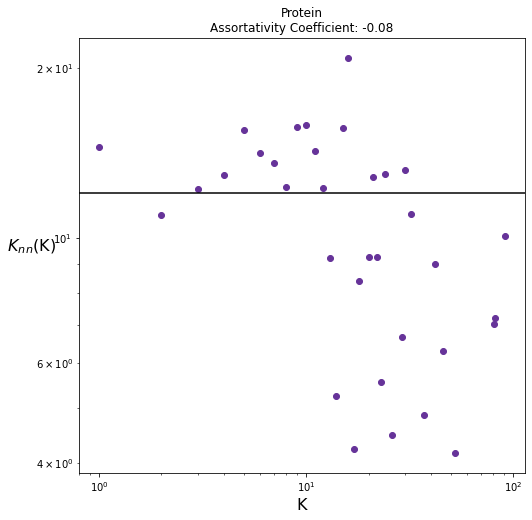

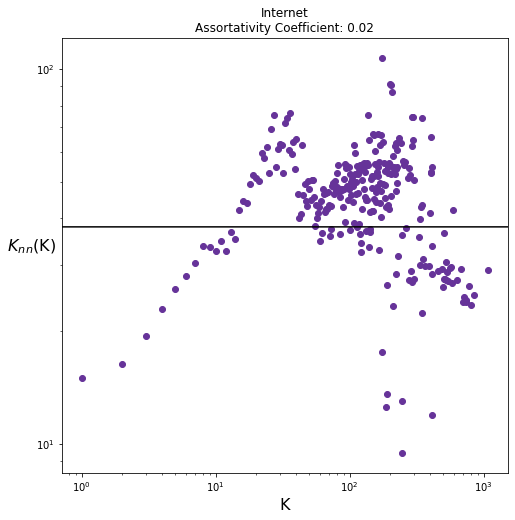

Actors


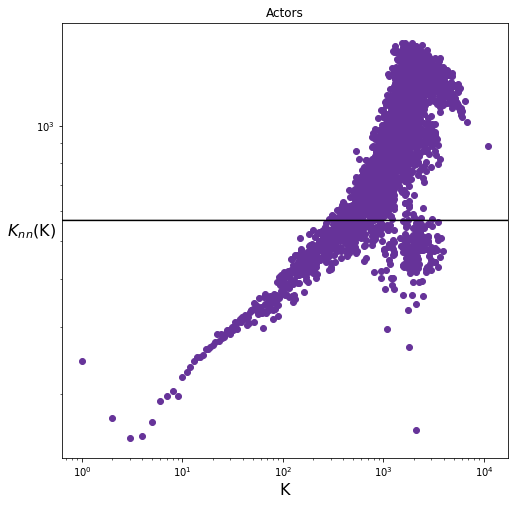

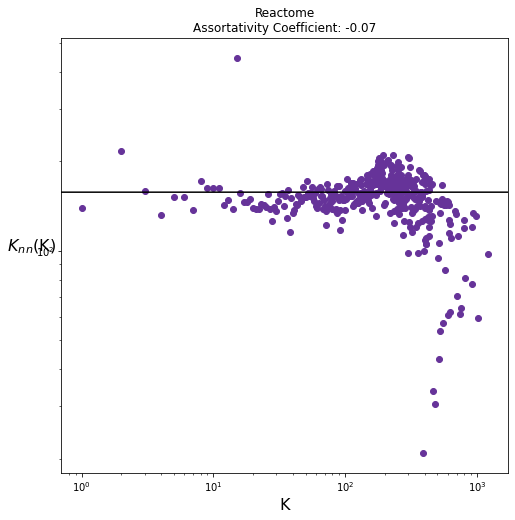

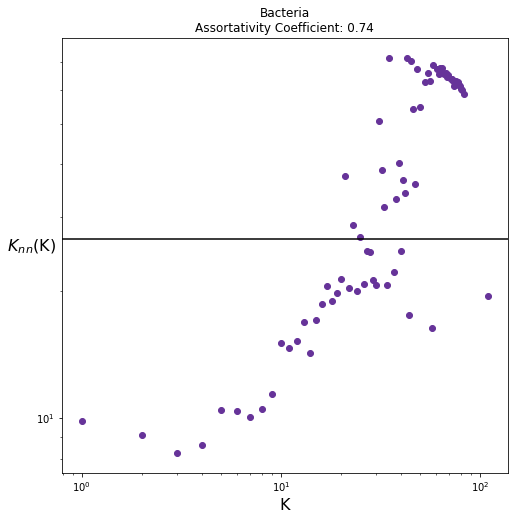

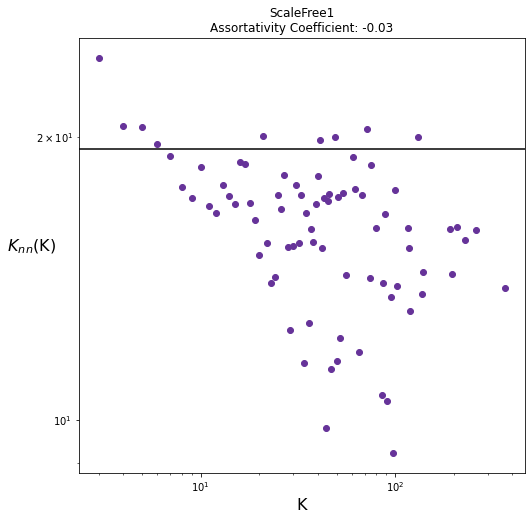

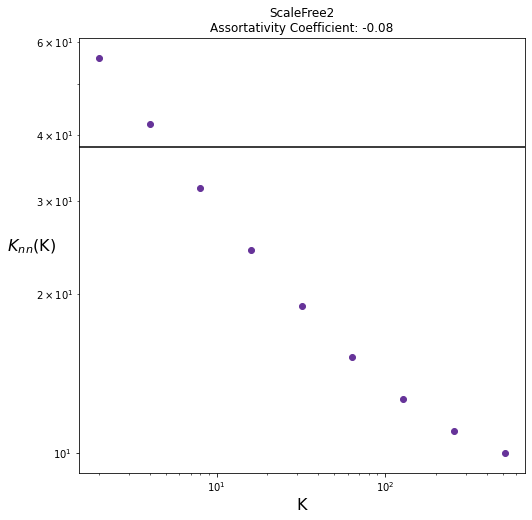

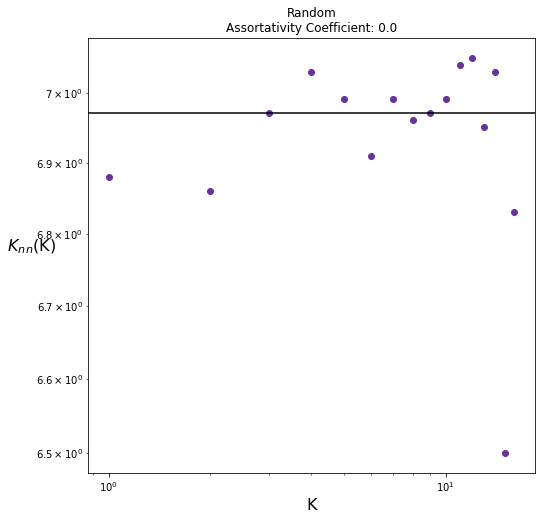

[None, None, None, None, None, None, None, None, None, None, None]

In [5]:
[averageNeighborsDegreeByDegree(networks[k]) for k in networks]